# Applied Data Science Capstone 
## Final Project
### 

import requests as rq
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

## Get lists of districts & neighborhoods from Wikipedia

Check connection to website

In [2]:
import requests
response = requests.get(
url="https://en.wikipedia.org/wiki/List_of_neighborhoods_of_Madrid")

if response.status_code == 200:
    print('Status Code:',response.status_code,'Success!')
elif response.status_code == 404:
    print('Status Code:',response.status_code,'Not Found.')

Status Code: 200 Success!


Import site content & beutify it using BeautifulSoup

In [3]:
from bs4 import BeautifulSoup
res = response.content
soup = BeautifulSoup(response.content,'lxml')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of neighborhoods of Madrid - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"X-eL7wpAAMMAAIZHQ20AAABX","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_neighborhoods_of_Madrid","wgTitle":"List of neighborhoods of Madrid","wgCurRevisionId":995373443,"wgRevisionId":995373443,"wgArticleId":26848967,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Short description is different from Wikidata","Wards of Madrid"],"wgPageCo

Find site table with neighborhoods & transform table to a Pandas dataframe

In [4]:
import pandas as pd
import numpy as np

#table = soup.find_all("table")
df = pd.read_html(str(soup))[0]
df

,District name (number),District location,Number,Name,Image
0,Centro (1),NaN,11,Palacio,NaN
1,Centro (1),NaN,12,Embajadores,NaN
2,Centro (1),NaN,13,Cortes,NaN
3,Centro (1),NaN,14,Justicia,NaN
4,Centro (1),NaN,15,Universidad,NaN
...,...,...,...,...,...
126,Barajas (21),NaN,211,Alameda de Osuna,NaN
127,Barajas (21),NaN,212,Aeropuerto,NaN
128,Barajas (21),NaN,213,Casco Histórico de Barajas,NaN
129,Barajas (21),NaN,214,Timón,NaN


Adjust Table 

In [4]:
del df['Number']
del df['Image']
del df['District location']
df.columns = ("District name","Neighborhood")
df['District name'] = df['District name'].str.replace('(','')
df['District name'] = df['District name'].str.replace(')','')
df['District name'] = df['District name'].str.replace('\d+', '')
df['District name'] = df['District name'].str.strip()
df['Neighborhood'] = df['Neighborhood'].str.strip()
#Create columns for latitude & longitude
#df["Latidude"] = np.nan
#df["Longitude"] = np.nan
df

,District name,Neighborhood
0,Centro,Palacio
1,Centro,Embajadores
2,Centro,Cortes
3,Centro,Justicia
4,Centro,Universidad
...,...,...
126,Barajas,Alameda de Osuna
127,Barajas,Aeropuerto
128,Barajas,Casco Histórico de Barajas
129,Barajas,Timón


## Get coordinates of each Neighborhood using Geopy API

Function to remove accents from string

In [5]:
import unicodedata

def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    return str(text)

In [6]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="tutorial")

from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.5)


In [7]:
country = "Madrid"
df['Adress'] = ""
df['location'] = ""

for n in df.index:
    district = df['District name'][n]
    neighborhood = df['Neighborhood'][n]
    location = neighborhood+","+district+","+country
    df.loc[n, 'Adress'] = location
    df.loc[n, 'Adress'] = strip_accents(df['Adress'][n])


df['location'] = df['Adress'].apply(geocode)
df['coord'] = df['location'].apply(lambda loc: tuple(loc.point) if loc else None)

In [8]:
df

,District name,Neighborhood,Adress,location,coord
0,Centro,Palacio,"Palacio,Centro,Madrid","(Palacio, Centro, Madrid, Área metropolitana d...","(40.41512925, -3.7156179983990922, 0.0)"
1,Centro,Embajadores,"Embajadores,Centro,Madrid","(Embajadores, Centro, Madrid, Área metropolita...","(40.409680550000004, -3.701644426413222, 0.0)"
2,Centro,Cortes,"Cortes,Centro,Madrid","(Cortes, Centro, Madrid, Área metropolitana de...","(40.4143476, -3.6985251827738512, 0.0)"
3,Centro,Justicia,"Justicia,Centro,Madrid","(Justicia, Centro, Madrid, Área metropolitana ...","(40.42395689999999, -3.6957473208550464, 0.0)"
4,Centro,Universidad,"Universidad,Centro,Madrid","(Universidad, Centro, Madrid, Área metropolita...","(40.425310350000004, -3.706629859074133, 0.0)"
...,...,...,...,...,...
126,Barajas,Alameda de Osuna,"Alameda de Osuna,Barajas,Madrid","(Alameda de Osuna, Calle de La Rioja, Barrio d...","(40.4575814, -3.5879745, 0.0)"
127,Barajas,Aeropuerto,"Aeropuerto,Barajas,Madrid","(Aeropuerto de Madrid-Barajas Adolfo Suárez, B...","(40.4948384, -3.5740806206811313, 0.0)"
128,Barajas,Casco Histórico de Barajas,"Casco Historico de Barajas,Barajas,Madrid",None,None
129,Barajas,Timón,"Timon,Barajas,Madrid","(Calle del Timón, Barajas, Madrid, Área metrop...","(40.4731709, -3.5841522, 0.0)"


In [9]:
df[['Latitude','longitude','aux']] = pd.DataFrame(df['coord'].to_list())
del df['aux']
del df['coord']
del df['location']
df

,District name,Neighborhood,Adress,Latitude,longitude
0,Centro,Palacio,"Palacio,Centro,Madrid",40.415129,-3.715618
1,Centro,Embajadores,"Embajadores,Centro,Madrid",40.409681,-3.701644
2,Centro,Cortes,"Cortes,Centro,Madrid",40.414348,-3.698525
3,Centro,Justicia,"Justicia,Centro,Madrid",40.423957,-3.695747
4,Centro,Universidad,"Universidad,Centro,Madrid",40.425310,-3.706630
...,...,...,...,...,...
126,Barajas,Alameda de Osuna,"Alameda de Osuna,Barajas,Madrid",40.457581,-3.587975
127,Barajas,Aeropuerto,"Aeropuerto,Barajas,Madrid",40.494838,-3.574081
128,Barajas,Casco Histórico de Barajas,"Casco Historico de Barajas,Barajas,Madrid",NaN,NaN
129,Barajas,Timón,"Timon,Barajas,Madrid",40.473171,-3.584152


Check Nan values

In [10]:
df.loc[np.isnan(df.Latitude)]

,District name,Neighborhood,Adress,Latitude,longitude
58,Latina,Los Cármenes,"Los Carmenes,Latina,Madrid",NaN,NaN
116,Vicálvaro,Valderrivas,"Valderrivas,Vicalvaro,Madrid",NaN,NaN
128,Barajas,Casco Histórico de Barajas,"Casco Historico de Barajas,Barajas,Madrid",NaN,NaN


API can't get the coordinates of three Neiborhoods, those will be discarted

In [11]:
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.loc[np.isnan(df.Latitude)]

,index,District name,Neighborhood,Adress,Latitude,longitude


## Plot Neighborhood using foluim

In [12]:
import folium # map rendering library
# create map of using latitude and longitude values
latitude = 40.416775
longitude =-3.703790
map_madrid = folium.Map(location=[latitude, longitude], zoom_start=12,tiles='Stamen Toner')
# add markers to map
locations = df[['Latitude', 'longitude']]
locationlist = locations.values.tolist()
    
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df['Neighborhood'][point],).add_to(map_madrid)

map_madrid

## Get data from FourSquared API

In [6]:
#FOURSQUARED API KEY

file = (r'C:\Users\marce\OneDrive\API Key\Foursquared API secret.csv')
#base_file = (r'C:/Users/marce/OneDrive - Gonvarri/KPI/df_bend.csv')
apikey = pd.read_csv(file)
CLIENT_ID = apikey['CLIENT_ID']
CLIENT_SECRET = apikey['CLIENT_SECRET']
VERSION = apikey['VERSION']
LIMIT = apikey['LIMIT']

In [7]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1500 # define radius
latitude = 40.416775
longitude =-3.703790
category = "4d4b7105d754a06376d81259" #Nightlife Spot category

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT,
    category
)

In [15]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ff7611acb7cea4da4bdf46a'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Sol',
  'headerFullLocation': 'Sol, Madrid',
  'headerLocationGranularity': 'neighborhood',
  'query': 'nightlife',
  'totalResults': 234,
  'suggestedBounds': {'ne': {'lat': 40.430275013500015,
    'lng': -3.6860913940481788},
   'sw': {'lat': 40.40327498649999, 'lng': -3.7214886059518215}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '57756e14498e605edcad54fc',
       'name': 'Salmon Gurú',
       'location': {'address': 'C. Echegaray, 21',
        'lat': 40.41486660560401,
        'lng': -3.6995319613728506,
        'labeledLatLngs': [{'label': 'display',
         

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    
    else:
        return categories_list[0]['name']

In [17]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

create function getNearbyVenues()

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    category = "4d4b7105d754a06376d81259"

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            category
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
madrid_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['longitude'])

Palacio
Embajadores
Cortes
Justicia
Universidad
Sol
Imperial
Acacias
Chopera
Legazpi
Delicias
Palos de Moguer
Atocha
Pacífico
Adelfas
Estrella
Ibiza
Los Jerónimos
Niño Jesús
Recoletos
Goya
Fuente del Berro
Guindalera
Lista
Castellana
El Viso
Prosperidad
Ciudad Jardín
Hispanoamérica
Nueva España
Castilla
Bellas Vistas
Cuatro Caminos
Castillejos
Almenara
Valdeacederas
Berruguete
Gaztambide
Arapiles
Trafalgar
Almagro
Ríos Rosas
Vallehermoso
El Pardo
Fuentelarreina
Peñagrande
Pilar
La Paz
Valverde
Mirasierra
El Goloso
Casa de Campo
Argüelles
Ciudad Universitaria
Valdezarza
Valdemarín
El Plantío
Aravaca
Puerta del Ángel
Lucero
Aluche
Campamento
Cuatro Vientos
Las Águilas
Comillas
Opañel
San Isidro
Vista Alegre
Puerta Bonita
Buenavista
Abrantes
Orcasitas
Orcasur
San Fermín
Almendrales
Moscardó
Zofío
Pradolongo
Entrevías
San Diego
Palomeras Bajas
Palomeras Sureste
Portazgo
Numancia
Pavones
Horcajo
Marroquina
Media Legua
Fontarrón
Vinateros
Ventas
Pueblo Nuevo
Quintana
Concepción
San Pascual
S

Count Venues found for each neiborhood

In [20]:
pd.set_option('display.max_rows', 150)
madrid_venues.groupby(by='Neighborhood').count().sort_values(by='Venue')

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Pavones,1,1,1,1,1,1
Aeropuerto,1,1,1,1,1,1
Valverde,1,1,1,1,1,1
Entrevías,1,1,1,1,1,1
Rosas,1,1,1,1,1,1
El Plantío,1,1,1,1,1,1
Castilla,2,2,2,2,2,2
Horcajo,3,3,3,3,3,3
Ciudad Universitaria,3,3,3,3,3,3


<IPython.core.display.Javascript object>


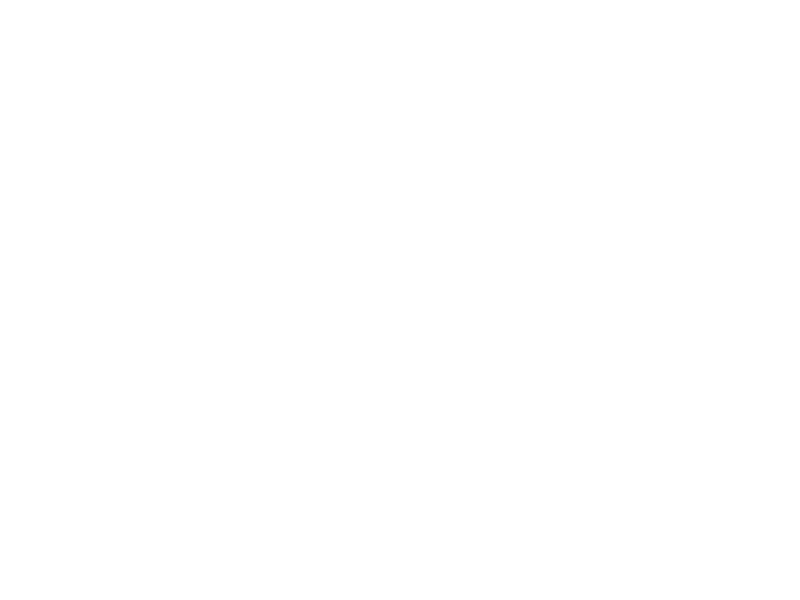

In [21]:
import seaborn as sns
%matplotlib notebook
import matplotlib.pyplot as plt

sns.ecdfplot(madrid_venues.groupby(by='Neighborhood').count().sort_values(by='Venue'), x="Venue")
plt.axvline(5, linewidth=0.5,color='r')
plt.axvline(10, linewidth=0.5,color='r')

30% of Neiborhoods has less than 5 bars, 75% of neiborhoods has less than 10 bars 

In [22]:

aux = madrid_venues.groupby(by='Neighborhood',as_index=False).count()
aux = aux[aux['Venue']>=5]
print(aux.shape[0],"Neiborhoods has more than 4 bars")
keep_neib = aux['Neighborhood'].tolist()


82 Neiborhoods has more than 4 bars


Filter dataframe with Neiborhoods with more than 4 bars

In [23]:
madrid_venues = madrid_venues[madrid_venues['Neighborhood'].isin(keep_neib)]
df = df[df['Neighborhood'].isin(keep_neib)]

## Analyze Each Neighborhood Venues

In [24]:
# one hot encoding
madrid_onehot = pd.get_dummies(madrid_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
madrid_onehot['Neighborhood'] = madrid_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [madrid_onehot.columns[-1]] + list(madrid_onehot.columns[:-1])
madrid_onehot = madrid_onehot[fixed_columns]

madrid_onehot.head()

,Neighborhood,American Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Breakfast Spot,...,Snack Place,Spanish Restaurant,Speakeasy,Sports Bar,Tapas Restaurant,Taverna,Theater,Whisky Bar,Wine Bar,Wine Shop
0,Palacio,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Palacio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Palacio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Palacio,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Palacio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
madrid_onehot.shape

(1362, 56)

Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [26]:
madrid_grouped = madrid_onehot.groupby('Neighborhood').mean().reset_index()
madrid_grouped

,Neighborhood,American Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Breakfast Spot,...,Snack Place,Spanish Restaurant,Speakeasy,Sports Bar,Tapas Restaurant,Taverna,Theater,Whisky Bar,Wine Bar,Wine Shop
0,Abrantes,0.000000,0.000000,0.666667,0.000000,0.166667,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
1,Acacias,0.000000,0.000000,0.611111,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.055556,0.00,0.000000,0.000000,0.000000,0.000000
2,Adelfas,0.000000,0.000000,0.625000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.125000,0.00,0.000000,0.000000,0.000000,0.000000
3,Alameda de Osuna,0.000000,0.000000,0.555556,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
4,Almagro,0.000000,0.024390,0.219512,0.024390,0.024390,0.00,0.024390,0.000000,0.000000,...,0.000000,0.048780,0.000000,0.000000,0.024390,0.00,0.000000,0.024390,0.000000,0.000000
5,Almenara,0.000000,0.000000,0.666667,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
6,Almendrales,0.000000,0.000000,0.200000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.200000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
7,Aluche,0.000000,0.000000,0.529412,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
8,Amposta,0.000000,0.000000,0.666667,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
9,Arapiles,0.000000,0.000000,0.461538,0.038462,0.038462,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.076923,0.038462,0.00,0.000000,0.000000,0.000000,0.000000


In [27]:
madrid_grouped.shape

(82, 56)

List top 05 venues in each neiborhood

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = madrid_grouped['Neighborhood']

for ind in np.arange(madrid_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Abrantes,Bar,Pub,Beer Garden,Coffee Shop,Ice Cream Shop
1,Acacias,Bar,Brewery,Pub,Hotel,Tapas Restaurant
2,Adelfas,Bar,Italian Restaurant,Tapas Restaurant,Brewery,Concert Hall
3,Alameda de Osuna,Bar,Pub,Cocktail Bar,Coffee Shop,Ice Cream Shop
4,Almagro,Bar,Nightclub,Pub,Brewery,Restaurant


Add a column with the ammount of bars

In [30]:

aux = madrid_venues.groupby(by='Neighborhood',as_index=False).count()
aux = aux[aux['Venue']>=5]

aux = aux[['Neighborhood','Venue']]
aux.columns = ['Neighborhood','Venue qty']
madrid_grouped = madrid_grouped.merge(aux,how='inner',left_on='Neighborhood', right_on='Neighborhood')
madrid_grouped

,Neighborhood,American Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Breakfast Spot,...,Spanish Restaurant,Speakeasy,Sports Bar,Tapas Restaurant,Taverna,Theater,Whisky Bar,Wine Bar,Wine Shop,Venue qty
0,Abrantes,0.000000,0.000000,0.666667,0.000000,0.166667,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,6
1,Acacias,0.000000,0.000000,0.611111,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.055556,0.00,0.000000,0.000000,0.000000,0.000000,18
2,Adelfas,0.000000,0.000000,0.625000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.125000,0.00,0.000000,0.000000,0.000000,0.000000,8
3,Alameda de Osuna,0.000000,0.000000,0.555556,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,9
4,Almagro,0.000000,0.024390,0.219512,0.024390,0.024390,0.00,0.024390,0.000000,0.000000,...,0.048780,0.000000,0.000000,0.024390,0.00,0.000000,0.024390,0.000000,0.000000,41
5,Almenara,0.000000,0.000000,0.666667,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,9
6,Almendrales,0.000000,0.000000,0.200000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.200000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,5
7,Aluche,0.000000,0.000000,0.529412,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,17
8,Amposta,0.000000,0.000000,0.666667,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,6
9,Arapiles,0.000000,0.000000,0.461538,0.038462,0.038462,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.076923,0.038462,0.00,0.000000,0.000000,0.000000,0.000000,26


## Get data from Idealista API

In [14]:
#Idealista API KEY
file = (r'C:\Users\marce\OneDrive\API Key\Foursquared API secret.csv')
apikey = pd.read_csv(file)
API_KEY = apikey['idealista API_KEY'][0]
SECRET = apikey['idealista SECRET'][0]

In [31]:
import json
import requests
import base64

def get_token():
    API_KEY= "0zggaa802aq673jas6ngsnhohh9xpupx"
    SECRET= "t8EGnDWQT9bg"
    message = API_KEY + ":" + SECRET
    auth = "Basic " + base64.b64encode(message.encode("ascii")).decode("ascii")

    headers_dic = {"Authorization" : auth,
                   "Content-Type" : "application/x-www-form-urlencoded;charset=UTF-8"}

    params_dic = {"grant_type" : "client_credentials",
                  "scope" : "read"}

    r = requests.post("https://api.idealista.com/oauth/token",
                      headers = headers_dic,
                      params = params_dic)

    bearer_token = json.loads(r.text)['access_token']

    return bearer_token


In [32]:
TOKEN = get_token()

In [33]:
def get_search(coord):
    headers_dic = {"Authorization" : "Bearer " + TOKEN,
                   "Content-Type" : "application/x-www-form-urlencoded"}

    params_dic = {"operation" : "rent",
                  "country" : "es",
                  "center" : coord,
                  "distance" : "2000",
                  "propertyType" : "homes",
                 "minSize" : 60,
                 "maxSize" : 100,
                 "bedrooms" : "1,2",
                 "bathrooms" : "1,2"
                 }

    r = requests.post("https://api.idealista.com/3.5/es/search",
                      headers = headers_dic,
                      params = params_dic)

    result_json = json.loads(r.text)

    return result_json

In [34]:
#embajadores

coord = ["40.409681,-3.701644"]
result = get_search(coord)
element_list = result['elementList']

In [35]:
element_list

[{'propertyCode': '92357565',
  'thumbnail': 'https://img3.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/9b/35/cc/837815048.jpg',
  'externalReference': 'A-JOHANA-302',
  'numPhotos': 14,
  'floor': '2',
  'price': 1150.0,
  'propertyType': 'flat',
  'operation': 'rent',
  'size': 63.0,
  'exterior': True,
  'rooms': 1,
  'bathrooms': 1,
  'address': 'Calle del Águila',
  'province': 'Madrid',
  'municipality': 'Madrid',
  'district': 'Centro',
  'country': 'es',
  'neighborhood': 'Palacio',
  'latitude': 40.4084427,
  'longitude': -3.711396,
  'showAddress': False,
  'url': 'https://www.idealista.com/inmueble/92357565/',
  'distance': '837',
  'hasVideo': True,
  'status': 'good',
  'newDevelopment': False,
  'hasLift': True,
  'priceByArea': 18.0,
  'detailedType': {'typology': 'flat'},
  'suggestedTexts': {'subtitle': 'Palacio, Madrid',
   'title': 'Piso en Calle del Águila'},
  'hasPlan': True,
  'has3DTour': False,
  'has360': False,
  'hasStaging': False,
  'topNewDevel

As Idealista only allows me to make 100 requests per month, I need to filter the database to neighborhoods with more than 10 bars

In [36]:
aux = madrid_venues.groupby(by='Neighborhood',as_index=False).count()
aux = aux[aux['Venue']>=10]
print(aux.shape[0],"Neiborhoods has more than 10 bars")
keep_neib = aux['Neighborhood'].tolist()

df2 = df[df['Neighborhood'].isin(keep_neib)]
df2


30 Neiborhoods has more than 10 bars


,index,District name,Neighborhood,Adress,Latitude,longitude
0,0,Centro,Palacio,"Palacio,Centro,Madrid",40.415129,-3.715618
1,1,Centro,Embajadores,"Embajadores,Centro,Madrid",40.409681,-3.701644
2,2,Centro,Cortes,"Cortes,Centro,Madrid",40.414348,-3.698525
3,3,Centro,Justicia,"Justicia,Centro,Madrid",40.423957,-3.695747
4,4,Centro,Universidad,"Universidad,Centro,Madrid",40.425310,-3.706630
5,5,Centro,Sol,"Sol,Centro,Madrid",40.417827,-3.702222
7,7,Arganzuela,Acacias,"Acacias,Arganzuela,Madrid",40.404075,-3.705957
9,9,Arganzuela,Legazpi,"Legazpi,Arganzuela,Madrid",40.391172,-3.695190
11,11,Arganzuela,Palos de Moguer,"Palos de Moguer,Arganzuela,Madrid",40.403638,-3.695289
13,13,Retiro,Pacífico,"Pacifico,Retiro,Madrid",40.401396,-3.674883


In [38]:
#LOAD MEAN_PRICE 
#mean_price.to_csv(r'C:\Users\marce\Desktop\Git_rep\IBM_FINAL_PROJECT\mean_price.csv',index=False)

file = (r'C:\Users\marce\Desktop\Git_rep\IBM_FINAL_PROJECT\mean_price.csv')
#base_file = (r'C:/Users/marce/OneDrive - Gonvarri/KPI/df_bend.csv')
mean_price = pd.read_csv(file)
mean_price

,Neighborhood,Price per area
0,Palacio,15.20
1,Embajadores,14.75
2,Cortes,15.75
3,Justicia,16.20
4,Universidad,16.20
5,Sol,15.50
6,Acacias,14.50
7,Legazpi,13.55
8,Palos de Moguer,14.70
9,Pacífico,13.35


In [39]:
mean_price = pd.DataFrame(mean_price)
mean_price.columns = ['Neighborhood','Price per area']
mean_price

,Neighborhood,Price per area
0,Palacio,15.20
1,Embajadores,14.75
2,Cortes,15.75
3,Justicia,16.20
4,Universidad,16.20
5,Sol,15.50
6,Acacias,14.50
7,Legazpi,13.55
8,Palos de Moguer,14.70
9,Pacífico,13.35


Mergue price per area to madrid_groped dataframe -- for neighborhoods without price data, replace nan for the mean price overall

In [40]:
mean_price_overall = mean_price['Price per area'].mean()
madrid_grouped = madrid_grouped.merge(mean_price,how='left',on='Neighborhood')
madrid_grouped = madrid_grouped.fillna(mean_price_overall)

madrid_grouped

#DataFrame.merge(right, how='inner', on=None, left_on=None, right_on=None, left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

,Neighborhood,American Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Breakfast Spot,...,Speakeasy,Sports Bar,Tapas Restaurant,Taverna,Theater,Whisky Bar,Wine Bar,Wine Shop,Venue qty,Price per area
0,Abrantes,0.000000,0.000000,0.666667,0.000000,0.166667,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,6,15.211667
1,Acacias,0.000000,0.000000,0.611111,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.055556,0.00,0.000000,0.000000,0.000000,0.000000,18,14.500000
2,Adelfas,0.000000,0.000000,0.625000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.125000,0.00,0.000000,0.000000,0.000000,0.000000,8,15.211667
3,Alameda de Osuna,0.000000,0.000000,0.555556,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,9,15.211667
4,Almagro,0.000000,0.024390,0.219512,0.024390,0.024390,0.00,0.024390,0.000000,0.000000,...,0.000000,0.000000,0.024390,0.00,0.000000,0.024390,0.000000,0.000000,41,16.450000
5,Almenara,0.000000,0.000000,0.666667,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,9,15.211667
6,Almendrales,0.000000,0.000000,0.200000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,5,15.211667
7,Aluche,0.000000,0.000000,0.529412,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,17,10.750000
8,Amposta,0.000000,0.000000,0.666667,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,6,15.211667
9,Arapiles,0.000000,0.000000,0.461538,0.038462,0.038462,0.00,0.000000,0.000000,0.000000,...,0.000000,0.076923,0.038462,0.00,0.000000,0.000000,0.000000,0.000000,26,16.100000


# Cluster Neighborhoods

In [41]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

madrid_grouped_clustering = madrid_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 0, 0, 1, 0, 0, 3, 0, 3])

Create a new dataframe that includes the cluster as well as the top 05 venues for each neighborhood.

In [43]:

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.insert(0, 'Venues qty', madrid_grouped['Venue qty'])
neighborhoods_venues_sorted.insert(0, 'Price per area', madrid_grouped['Price per area'])

madrid_merged = df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
madrid_merged = madrid_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

madrid_merged.sort_values(by='Cluster Labels') # check the last columns!

,index,District name,Neighborhood,Adress,Latitude,longitude,Price per area,Venues qty,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
126,129,Barajas,Timón,"Timon,Barajas,Madrid",40.473171,-3.584152,15.211667,5,0,Gastropub,Wine Bar,Bar,Brewery,Concert Hall
29,29,Chamartín,Nueva España,"Nueva Espana,Chamartin,Madrid",40.462594,-3.678735,14.950000,10,0,Bar,Cocktail Bar,Pub,Nightclub,Brewery
31,31,Tetuán,Bellas Vistas,"Bellas Vistas,Tetuan,Madrid",40.452791,-3.707013,15.211667,6,0,Bar,Pub,Tapas Restaurant,Spanish Restaurant,Cocktail Bar
90,91,Ciudad Lineal,Ventas,"Ventas,Ciudad Lineal,Madrid",40.422040,-3.651707,15.211667,6,0,Bar,Beer Garden,Brewery,Wine Shop,Concert Hall
89,90,Moratalaz,Vinateros,"Vinateros,Moratalaz,Madrid",40.405197,-3.641547,15.211667,5,0,Brewery,Bar,Wine Shop,Concert Hall,Ice Cream Shop
34,34,Tetuán,Almenara,"Almenara,Tetuan,Madrid",40.470196,-3.693638,15.211667,9,0,Bar,Cocktail Bar,Brewery,Restaurant,Concert Hall
36,36,Tetuán,Berruguete,"Berruguete,Tetuan,Madrid",40.460271,-3.704345,15.211667,7,0,Bar,Tapas Restaurant,Brewery,Restaurant,Wine Shop
88,89,Moratalaz,Fontarrón,"Fontarron,Moratalaz,Madrid",40.399161,-3.646206,15.211667,5,0,Bar,Brewery,Wine Shop,Concert Hall,Ice Cream Shop
86,87,Moratalaz,Marroquina,"Marroquina,Moratalaz,Madrid",40.410719,-3.640568,15.211667,7,0,Bar,Brewery,Nightlife Spot,Wine Shop,Concert Hall
82,83,Puente de Vallecas,Portazgo,"Portazgo,Puente de Vallecas,Madrid",40.391437,-3.648126,15.211667,5,0,Bar,Tapas Restaurant,Brewery,Wine Shop,Concert Hall


Create map with clusters

In [44]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11,tiles='Stamen Toner')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_merged['Latitude'], madrid_merged['longitude'], madrid_merged['Neighborhood'], madrid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

In [45]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 0, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

,District name,longitude,Price per area,Venues qty,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Arganzuela,-3.717322,15.211667,9,0,Bar,Karaoke Bar,Brewery,Gastropub,Café
8,Arganzuela,-3.699705,15.211667,9,0,Bar,Cocktail Bar,Tapas Restaurant,Beer Garden,Gastropub
10,Arganzuela,-3.689495,15.211667,7,0,Bar,Gastropub,Spanish Restaurant,Brewery,Wine Shop
12,Arganzuela,-3.682176,15.211667,7,0,Bar,Tapas Restaurant,Spanish Restaurant,Nightclub,Wine Shop
13,Retiro,-3.674883,13.350000,14,0,Bar,Pub,Spanish Restaurant,Brewery,Nightclub
14,Retiro,-3.670958,15.211667,8,0,Bar,Italian Restaurant,Tapas Restaurant,Brewery,Concert Hall
15,Retiro,-3.666998,15.211667,6,0,Bar,Cocktail Bar,Brewery,Jazz Club,Concert Hall
18,Retiro,-3.673720,15.211667,8,0,Piano Bar,Tapas Restaurant,Pub,Brewery,Spanish Restaurant
21,Salamanca,-3.663700,15.211667,6,0,Bar,Gastropub,Brewery,Restaurant,Wine Shop
22,Salamanca,-3.668019,15.211667,7,0,Bar,Hotel Bar,Gastropub,Brewery,Restaurant


In [46]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 1, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

,District name,longitude,Price per area,Venues qty,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Centro,-3.715618,15.20,30,1,Bar,Cocktail Bar,Gastropub,Tapas Restaurant,Beer Bar
5,Centro,-3.702222,15.50,39,1,Cocktail Bar,Bar,Nightclub,Wine Bar,Tapas Restaurant
19,Salamanca,-3.685743,15.50,38,1,Cocktail Bar,Nightclub,Bar,Gastropub,American Restaurant
20,Salamanca,-3.675843,17.35,30,1,Bar,Tapas Restaurant,Brewery,Lounge,Restaurant
24,Salamanca,-3.684132,15.05,39,1,Bar,Nightclub,Gastropub,Cocktail Bar,Tapas Restaurant
37,Chamberí,-3.714903,15.60,33,1,Bar,Pub,Nightclub,Beer Garden,Cocktail Bar
40,Chamberí,-3.693044,16.45,41,1,Bar,Nightclub,Pub,Brewery,Restaurant
41,Chamberí,-3.697835,16.15,35,1,Bar,Café,Brewery,Gastropub,Cocktail Bar


In [47]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 2, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

,District name,longitude,Price per area,Venues qty,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Centro,-3.695747,16.2,100,2,Gay Bar,Bar,Cocktail Bar,Gastropub,Nightclub
4,Centro,-3.706630,16.2,100,2,Bar,Cocktail Bar,Gastropub,Pub,Tapas Restaurant


In [48]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 3, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

,District name,longitude,Price per area,Venues qty,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7,Arganzuela,-3.705957,14.50,18,3,Bar,Brewery,Pub,Hotel,Tapas Restaurant
9,Arganzuela,-3.695190,13.55,16,3,Bar,Beer Garden,Pub,Spanish Restaurant,Wine Bar
11,Arganzuela,-3.695289,14.70,28,3,Bar,Brewery,Beer Garden,Spanish Restaurant,Pub
16,Retiro,-3.673725,15.65,21,3,Brewery,Bar,Cocktail Bar,Gastropub,Spanish Restaurant
17,Retiro,-3.690352,16.60,17,3,Nightclub,Beer Garden,Gastropub,Cocktail Bar,Coffee Shop
23,Salamanca,-3.674509,16.40,25,3,Bar,Brewery,Cocktail Bar,Nightclub,Lounge
26,Chamartín,-3.670166,16.70,28,3,Bar,Cocktail Bar,Pub,Brewery,Lounge
28,Chamartín,-3.677202,15.40,26,3,Bar,Pub,Gastropub,Nightclub,Cocktail Bar
32,Tetuán,-3.697800,15.40,26,3,Nightclub,Bar,Gastropub,Pub,Spanish Restaurant
33,Tetuán,-3.694067,14.85,24,3,Bar,Brewery,Nightclub,Cocktail Bar,Pub


In [49]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 4, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

,District name,longitude,Price per area,Venues qty,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Centro,-3.701644,14.75,62,4,Bar,Cocktail Bar,Tapas Restaurant,Café,Bistro
2,Centro,-3.698525,15.75,64,4,Bar,Nightclub,Wine Bar,Cocktail Bar,Spanish Restaurant
39,Chamberí,-3.701246,16.25,57,4,Bar,Brewery,Nightclub,Pub,Tapas Restaurant


In [51]:
summary = []
for i in range(0,5):
    aux = madrid_merged[madrid_merged['Cluster Labels'] == i]
    price = np.mean(aux['Price per area'])
    qty = np.mean(aux['Venues qty'])
    summary.append([i,price,qty])
summary = pd.DataFrame(summary)
summary.columns = ['Cluster','Price per area','Qty Venues']
summary

,Cluster,Price per area,Qty Venues
0,0,15.111939,6.890909
1,1,15.850000,35.625000
2,2,16.200000,100.000000
3,3,15.017857,22.500000
4,4,15.583333,61.000000
